# Time to get your hands dirty: The HR diagram (...and the importance of data scaling in machine learning)
This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:
- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)


- Apply PCA to the dataset at your disposal *(hint: don't use columns with labels, only those with real numbers)*.
- Project the dataset into the principal components, and do a scatter plot of the first two.
- This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.

**This is actually a very important lesson in machine learning:**  
Massaging your data before giving them to an algorithm can make things much much better.

- You can try a linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is the [usual machine-learning approach](https://scikit-learn.org/stable/modules/preprocessing.html)) standardize your data such that each dimension has mean = 0 and variance = 1.
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?

---

## For later: come back to this assignment after lecture 20

- Now run a supervised classification algorithm on this dataset.
- Can you predict the stellar type? How well? Careful with overfitting of course.


In [50]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")


import pandas as pd
df_stars = pd.read_csv("stars.csv")


df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


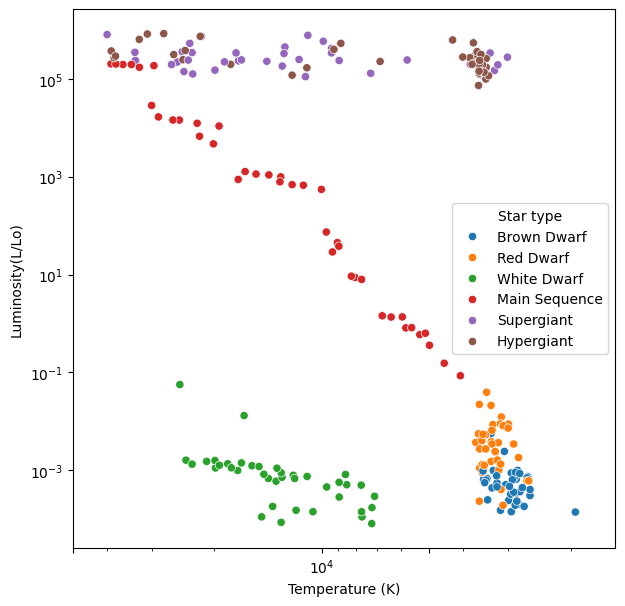

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue='Star type')

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()
# H-R diagram

In [52]:
print(df_stars.isna().any().any()) #check for missing values

False


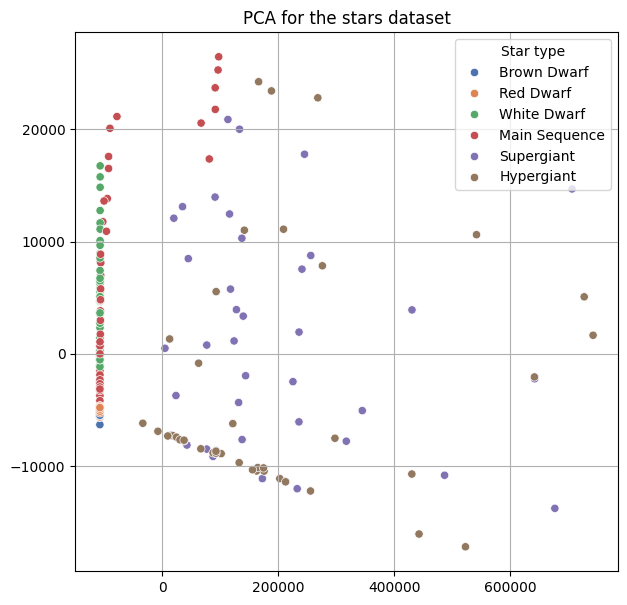

In [53]:
from sklearn.decomposition import PCA

#let's ignore the column with words
features = df_stars.drop(columns=['Star color', 'Star type', 'Spectral Class'])

pca = PCA(n_components=2, svd_solver='randomized')
pca_result = pca.fit_transform(features)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_stars['Star type'], palette='deep')
plt.title('PCA for the stars dataset')
plt.grid(True)
plt.show()

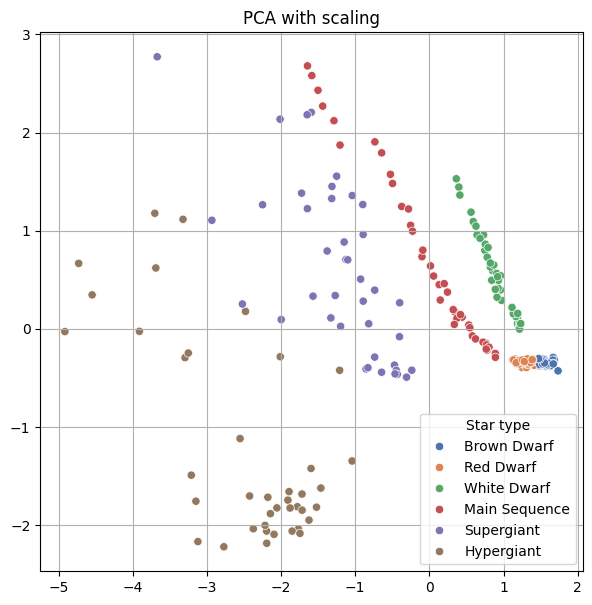

In [54]:
# now, try the PCA by scaling the dataset 

from sklearn.preprocessing import StandardScaler
features = df_stars.drop(columns=['Star color', 'Star type', 'Spectral Class'])

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#This scaling process is necessary because the variables have different scales.
#If I don't standardize the Temperature, being numerically much larger, it will dominate the PCA.
#Standardizing means transforming the data by centering them to 0 with a dispersion of 1.

pca = PCA(n_components=2, svd_solver='randomized')
pca_result = pca.fit_transform(features_scaled)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_stars['Star type'], palette='deep')
plt.title('PCA with scaling')
plt.grid(True)
plt.show()

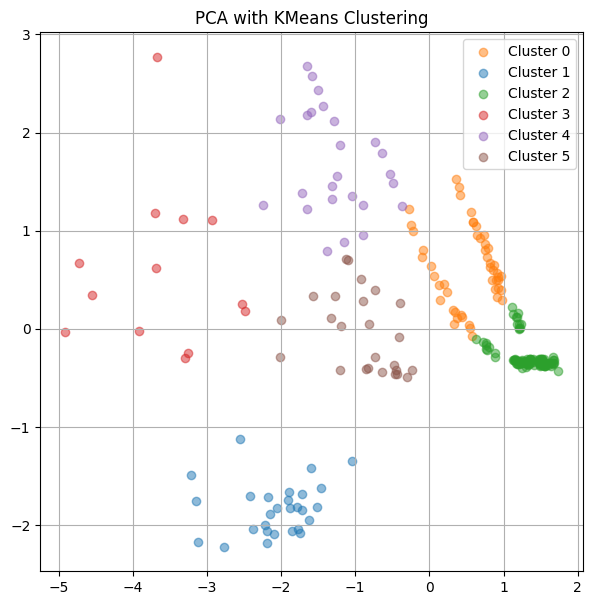

In [55]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

kmeans = KMeans(n_clusters=6, n_init='auto', random_state=42)
kmeans.fit(pca_result)
labels = kmeans.predict(pca_result)

colors = ['C1', 'C0', 'C2', 'C3', 'C4', 'C5']
plt.figure(figsize=(7, 7))
plt.scatter(pca_result[labels == 0, 0], pca_result[labels == 0, 1], color=colors[0], alpha=0.5, label='Cluster 0')
plt.scatter(pca_result[labels == 1, 0], pca_result[labels == 1, 1], color=colors[1], alpha=0.5, label='Cluster 1')
plt.scatter(pca_result[labels == 2, 0], pca_result[labels == 2, 1], color=colors[2], alpha=0.5, label='Cluster 2')
plt.scatter(pca_result[labels == 3, 0], pca_result[labels == 3, 1], color=colors[3], alpha=0.5, label='Cluster 3')
plt.scatter(pca_result[labels == 4, 0], pca_result[labels == 4, 1], color=colors[4], alpha=0.5, label='Cluster 4')
plt.scatter(pca_result[labels == 5, 0], pca_result[labels == 5, 1], color=colors[5], alpha=0.5, label='Cluster 5')

plt.title('PCA with KMeans Clustering')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score 

# Converti etichette vere in numeri interi
le = LabelEncoder()
true_labels_encoded = le.fit_transform(df_stars['Star type'])

# Riassegna i cluster per allinearli ai veri label
new_labels = np.zeros_like(labels)
for cluster in np.unique(labels):
    mask = labels == cluster
    new_labels[mask] = mode(true_labels_encoded[mask], keepdims=True).mode[0]

# Stampa la matrice di confusione
cm = confusion_matrix(true_labels_encoded, new_labels)
print("Confusion Matrix:\n", cm)

print("Accuracy for the INCOMPLETE model:", accuracy_score(true_labels_encoded, new_labels))



Confusion Matrix:
 [[40  0  0  0  0  0]
 [ 0 38  0  0  2  0]
 [ 9  0  0  0 11 20]
 [40  0  0  0  0  0]
 [ 0  3  0  0 37  0]
 [11  0  0  0  0 29]]
Accuracy for the INCOMPLETE model: 0.6


In [57]:
#let's include the three columns with words

from sklearn.preprocessing import LabelEncoder

# change the columns with name into numbers
le_type = LabelEncoder()
le_color = LabelEncoder()
le_spec = LabelEncoder()

# Codify "Star type"
df_stars['Star type'] = le_type.fit_transform(df_stars['Star type'])
labels = le_type.inverse_transform(df_stars['Star type'])  # per i grafici
class_names = le_type.classes_
print("Star type:", class_names)

# Codify "Star color"
df_stars['Star color'] = le_color.fit_transform(df_stars['Star color'])
print("Star color:", le_color.classes_)

# Codify "Spectral Class"
df_stars['Spectral Class'] = le_spec.fit_transform(df_stars['Spectral Class'])
print("Spectral Class:", le_spec.classes_)


""""
that's do 2 things:
1. `le.fit(...)`: find all the unique values into the column 'Star type' (es. "White Dwarf", "Red Giant", ecc.).
2. `le.transform(...)`: give at each values an integer number (es. "White Dwarf" → 0, "Red Giant" → 1, ...).
"""

# ATTENZIONE, QUESTO NON STA MIGLIORANDO NULLA PERCHè PER COME LE HO CONVERTITE IPOTIZZO LINEARITà NEL CAMBIO DI COLORE, MA I VALORI NON SONO NE IN ORDINE CRESCENTE NE TANTO MENO EQUIDISTANTI!!
# QUESTO INTRODUCE RUMORE !!!


Star type: ['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']
Star color: ['Blue' 'Blue ' 'Blue White' 'Blue white' 'Blue white ' 'Blue-White'
 'Blue-white' 'Orange' 'Orange-Red' 'Pale yellow orange' 'Red' 'White'
 'White-Yellow' 'Whitish' 'Yellowish' 'Yellowish White' 'white'
 'yellow-white' 'yellowish']
Spectral Class: ['A' 'B' 'F' 'G' 'K' 'M' 'O']


'"\nthat\'s do 2 things:\n1. `le.fit(...)`: find all the unique values into the column \'Star type\' (es. "White Dwarf", "Red Giant", ecc.).\n2. `le.transform(...)`: give at each values an integer number (es. "White Dwarf" → 0, "Red Giant" → 1, ...).\n'

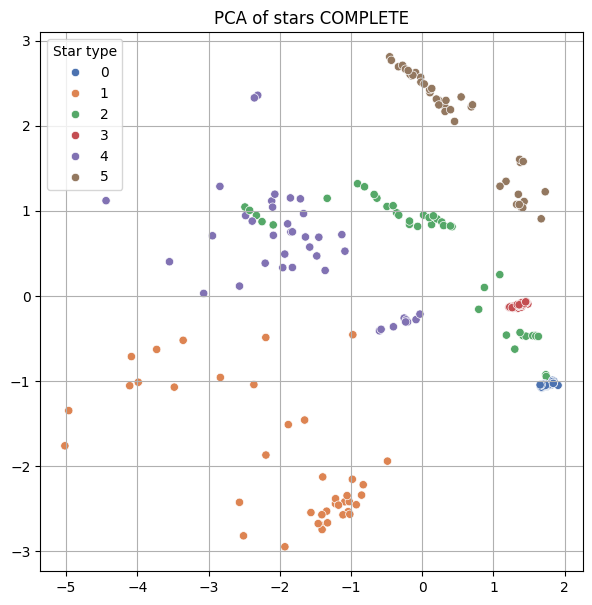

In [58]:

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_stars)

pca = PCA(n_components=2, svd_solver='randomized')
pca_result = pca.fit_transform(features_scaled)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_stars['Star type'], palette='deep')
plt.title('PCA of stars COMPLETE')
plt.grid(True)
plt.show()



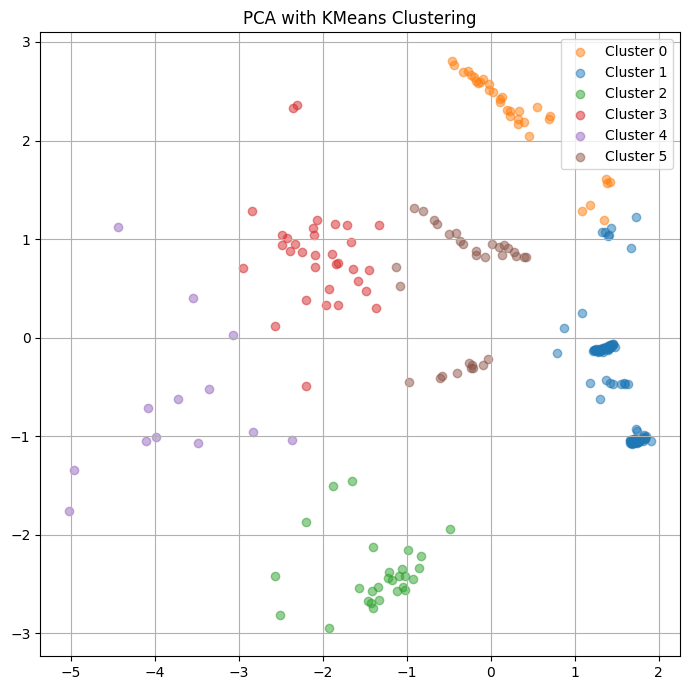

In [60]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

kmeans = KMeans(n_clusters=6, n_init='auto', random_state=42)
kmeans.fit(pca_result)
labels = kmeans.predict(pca_result)

colors = ['C1', 'C0', 'C2', 'C3', 'C4', 'C5']
plt.figure(figsize=(7, 7))
plt.scatter(pca_result[labels == 0, 0], pca_result[labels == 0, 1], color=colors[0], alpha=0.5, label='Cluster 0')
plt.scatter(pca_result[labels == 1, 0], pca_result[labels == 1, 1], color=colors[1], alpha=0.5, label='Cluster 1')
plt.scatter(pca_result[labels == 2, 0], pca_result[labels == 2, 1], color=colors[2], alpha=0.5, label='Cluster 2')
plt.scatter(pca_result[labels == 3, 0], pca_result[labels == 3, 1], color=colors[3], alpha=0.5, label='Cluster 3')
plt.scatter(pca_result[labels == 4, 0], pca_result[labels == 4, 1], color=colors[4], alpha=0.5, label='Cluster 4')
plt.scatter(pca_result[labels == 5, 0], pca_result[labels == 5, 1], color=colors[5], alpha=0.5, label='Cluster 5')

plt.title('PCA with KMeans Clustering')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score 

# Converti etichette vere in numeri interi
le = LabelEncoder()
true_labels_encoded = le.fit_transform(df_stars['Star type'])

# Riassegna i cluster per allinearli ai veri label
new_labels = np.zeros_like(labels)
for cluster in np.unique(labels):
    mask = labels == cluster
    new_labels[mask] = mode(true_labels_encoded[mask], keepdims=True).mode[0]

# Stampa la matrice di confusione
cm = confusion_matrix(true_labels_encoded, new_labels)
print("Confusion Matrix:\n", cm)

print("Accuracy for the COMPLETE model:", accuracy_score(true_labels_encoded, new_labels))



Confusion Matrix:
 [[40  0  0  0  0  0]
 [ 0 38  1  0  1  0]
 [14  0 20  0  6  0]
 [40  0  0  0  0  0]
 [ 0  3 11  0 26  0]
 [ 7  0  0  0  0 33]]
Accuracy for the COMPLETE model: 0.6541666666666667
